# 1. load modules, functions, and data

In [1]:
# setting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nltools.stats import fisher_r_to_z
from nilearn.glm.first_level import glover_hrf
import matplotlib.patches as patches
from scipy.signal import argrelextrema

import scipy.stats as stats
from scipy.signal import decimate
from scipy.stats import zscore, pearsonr, kendalltau,  entropy, spearmanr, linregress, rankdata, ttest_rel, ttest_1samp, ttest_ind, zscore
from statsmodels.stats.multitest import multipletests, fdrcorrection
from sklearn.metrics import jaccard_score
from sklearn import manifold
from itertools import permutations, combinations, product
from nltools.stats import fdr, threshold, regress, one_sample_permutation
from nltools.external import glover_hrf

from nltools.file_reader import onsets_to_dm
from nltools.stats import regress
from nltools.data import Brain_Data, Design_Matrix
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from nilearn import datasets
from nilearn.image import index_img, mean_img


In [113]:
def extract_recalledidx_all(group):
    keys = [f'sub-0{group}01',f'sub-0{group}02',f'sub-0{group}03']

    data_transcript = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{str(group)}/group-0{str(group)} sharedeb.xlsx')
    sharedeb = np.array(data_transcript['sharedeb'])
    data_recs = np.array(data_transcript[keys])
    recalled_evidx_all_oh = np.zeros((sharedeb[-1],3))
    recalled_evs_all = np.zeros((sharedeb[-1],3), dtype='object')
    for i in range(len(sharedeb)):
        for j in range(3):
            if (type(data_recs[i,j])==str or np.isnan(data_recs[i,j])==False) and (data_recs[i,j]!=0):
                recalled_evidx_all_oh[int(sharedeb[i])-1,j] = 1
                recalled_evs_all[int(sharedeb[i])-1,j] = str(data_recs[i,j])
    return recalled_evidx_all_oh, recalled_evs_all

def get_boundary(group,sub):
    groupsub = group+sub
    word_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_AUDIO/derivatives/group-{group}/sub-{groupsub}_run-1_day2_words.xlsx')
    posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV/group-{group}/sub-{groupsub}_day2_posthoc.xlsx')
    # word_data.keys() = start, end, word
    # posthoc_data.keys() = sentence, segmentation, description, tag
    words = word_data['word']
    start = word_data['start']
    end = word_data['end']
    sentstartend = []
    eventstartend = []

    segcol = posthoc_data['segmentation']

    # 아래가 concat의 원리
    tmpstart = start[0]
    for i in range (len(words)-1):
        if '.' in str(words[i]) or ',' in str(words[i]) or '었고' in str(words[i]) or '것 같고' in str(words[i]) or '지고' in str(words[i]) or '는데' in str(words[i]) or '근데' in str(words[i]) or '그리고' in str(words[i]) or '그러고' in str(words[i]) or '됐고' in str(words[i]) or '했고' in str(words[i]): 
            tmpend = end[i]
            sentstartend.append([tmpstart,tmpend])
            tmpstart = start[i+1]
    tmpend = end[len(words)-1]
    sentstartend.append([tmpstart,tmpend])

    tmpstart = sentstartend[0][0]
    boundary = []
    for i in range (len(segcol)-1):
        if segcol[i] != segcol[i+1]:
            boundary.append(sentstartend[i][1])            
            eventstartend.append([tmpstart,sentstartend[i][1]])
            tmpstart = sentstartend[i+1][0]
    tmpend = sentstartend[-1][1]
    eventstartend.append([tmpstart,tmpend])    
    
    return eventstartend, boundary

def get_boundary2(group,sub,run):
    groupsub = '0'+str(group)+'0'+str(sub)
    word_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_AUDIO/derivatives/group-0{group}/sub-{groupsub}_run-{run}_day2_words.xlsx')
    posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{group}/sub-{groupsub}_day2_posthoc.xlsx')
    # word_data.keys() = start, end, word
    # posthoc_data.keys() = sentence, segmentation, description, tag
    words = word_data['word']
    start = word_data['start']
    end = word_data['end']
    sentstartend = []
    eventstartend = []
    endidx = [0]
    for t in range (len(posthoc_data['Unnamed: 0'])-1):
        if posthoc_data['Unnamed: 0'][t]+1 != posthoc_data['Unnamed: 0'][t+1]:
            endidx.append(t)
    endidx.append(len(posthoc_data['Unnamed: 0'])-1)
    if len(endidx)>2:
        segcol = np.array(posthoc_data['segmentation'][endidx[run-1]+1:endidx[run]+1])
    else:
        segcol = np.array(posthoc_data['segmentation'])

    tmpstart = start[0]
    for i in range (len(words)-1):
        if '.' in str(words[i]) or ',' in str(words[i]) or '었고' in str(words[i]) or '것 같고' in str(words[i]) or '지고' in str(words[i]) or '는데' in str(words[i]) or '근데' in str(words[i]) or '그리고' in str(words[i]) or '그러고' in str(words[i]) or '됐고' in str(words[i]) or '했고' in str(words[i]): 
            tmpend = end[i]
            sentstartend.append([tmpstart,tmpend])
            tmpstart = start[i+1]
    tmpend = end[len(words)-1]
    sentstartend.append([tmpstart,tmpend])

    # working for subs with only 1 run
    tmpstart = sentstartend[0][0]
    for i in range (len(segcol)-1):
        if segcol[i] != segcol[i+1]:     
            tmpend = sentstartend[i][1]     
            eventstartend.append([tmpstart,tmpend])
            tmpstart = sentstartend[i+1][0]
    tmpend = sentstartend[len(segcol)-1][1]
    eventstartend.append([tmpstart,tmpend]) 
    
    return eventstartend

def get_motion_params(group, sub, run):
    fname = f'/home/jiunchoi/OFD/OFD_DATA/derivatives/sub-0{str(group)}0{str(sub)}/func/sub-0{str(group)}0{str(sub)}_task-RECALL_run-{run}_desc-confounds_timeseries.tsv'
    compounds = pd.read_csv(fname, delimiter='\t')
    confound_labels =  ['trans_x', 
                    'trans_y', 
                    'trans_z',
                    'rot_x',
                    'rot_y',
                    'rot_z',
                    'trans_x_derivative1',
                    'trans_y_derivative1',
                    'trans_z_derivative1',
                    'rot_x_derivative1',
                    'rot_y_derivative1',
                    'rot_z_derivative1',
                    'trans_x_power2',
                    'trans_y_power2',
                    'trans_z_power2',
                    'rot_x_power2',
                    'rot_y_power2',
                    'rot_z_power2',
                    'trans_x_derivative1_power2',
                    'trans_y_derivative1_power2',
                    'trans_z_derivative1_power2',
                    'rot_x_derivative1_power2',
                    'rot_y_derivative1_power2',
                    'rot_z_derivative1_power2']
    X_motion = compounds[confound_labels]
    X_motion = np.nan_to_num(X_motion)
    return X_motion

In [135]:
MASKDIR = '/home/jiunchoi/OFD/source/'
DATADIR = '/home/jiunchoi/OFD/OFD_DATA/derivatives/'
BN_atlas = nib.load(f'{MASKDIR}BNA_3mm_atlas.nii').get_fdata()

def load_brain(group,sub,run):
    task = 'RECALL'
    BN_parcels = np.zeros((246), dtype='object')
    groupsub = '0'+str(group)+'0'+str(sub)
    fmri_data = nib.load(f'{DATADIR}sub-{groupsub}/preprocessed/sub-{groupsub}_RECALL_{run}_sc_dt_sm.nii.gz').get_fdata()
    for roi in range (1,246+1):
        roi_data = fmri_data[BN_atlas==roi, :].T #(Time, Voxels)
        roi_data = zscore(roi_data, axis=0)
        roi_data = np.nan_to_num(roi_data)
        BN_parcels[roi-1] = roi_data
    return BN_parcels

def load_epi(group, sub, run):
    groupsub = '0'+str(group)+'0'+str(sub)
    fmri_data = nib.load(f'{DATADIR}sub-{groupsub}/preprocessed/sub-{groupsub}_RECALL_{run}_sc_dt_sm.nii.gz').get_fdata()
    fmri_data = np.nan_to_num(fmri_data)
    return fmri_data

In [217]:
brain_mask = nib.load('/home/jiunchoi/OFD/source/MNI152NLin2009cAsym_3mm_mask.nii').get_fdata()
groups=[2,3,4,5]
group_brain = np.zeros((len(groups),3), dtype='object')

for group in groups:
    for sub in [1,2,3]:
        sub_brain = []
        if (group==2 and sub==1):
            runs = [1,2,3]
        else:
            runs = [1]
        for run in runs:
            sub_brain.append(zscore(load_epi(group,sub,run)[brain_mask==1], axis=0))
        group_brain[group-2,sub-1] = sub_brain

# 2. load BHV data to regressor

In [174]:
group_reg = np.zeros_like(group_brain, dtype='object')

for group in [2,3,4,5]:
    recalled_evidx_all_oh, recalled_evs_all = extract_recalledidx_all(int(group))
    recalled_evs_all_param = np.sum(recalled_evidx_all_oh, axis=1)

    for sub in [1,2,3]:
        posthoc_data = pd.read_excel(f'/home/jiunchoi/OFD/OFD_BHV_clean/group-0{group}/sub-0{group}0{sub}_day2_posthoc.xlsx')
        segcol = np.array(posthoc_data['segmentation'])
        
        # 우선 개인별로 이벤트에 param을 담아
        oh_sum = np.zeros(int(max(segcol)))
        for r,reao in enumerate(recalled_evidx_all_oh):
            if reao[sub-1] == 1:
                targets = str(recalled_evs_all[r,sub-1]).split(',')
                for target in targets:
                    targetidx = int(float(target))
                    oh_sum[targetidx-1] = recalled_evs_all_param[r]

        # get eventstartend
        sub_reg = []
        if (group==2 and sub==1):
            runs = [1,2,3]
        else:
            runs = [1]
        eventstartend = []
        for run in runs:
            evse = get_boundary2(group,sub,run)
            eventstartend = np.array(evse)

            # make regressor fitted to TR
            X = np.zeros((len(group_brain[group-2,sub-1][run-1][0,:])))
            for e, ese in enumerate(eventstartend):
                startTR = math.trunc(ese[0]/1000)
                endTR = math.ceil(ese[1]/1000)
                X[startTR:endTR] = oh_sum[e]
                X_hrf = np.convolve(X, glover_hrf(1))
            sub_reg.append(X_hrf)
        group_reg[group-2,sub-1] = sub_reg

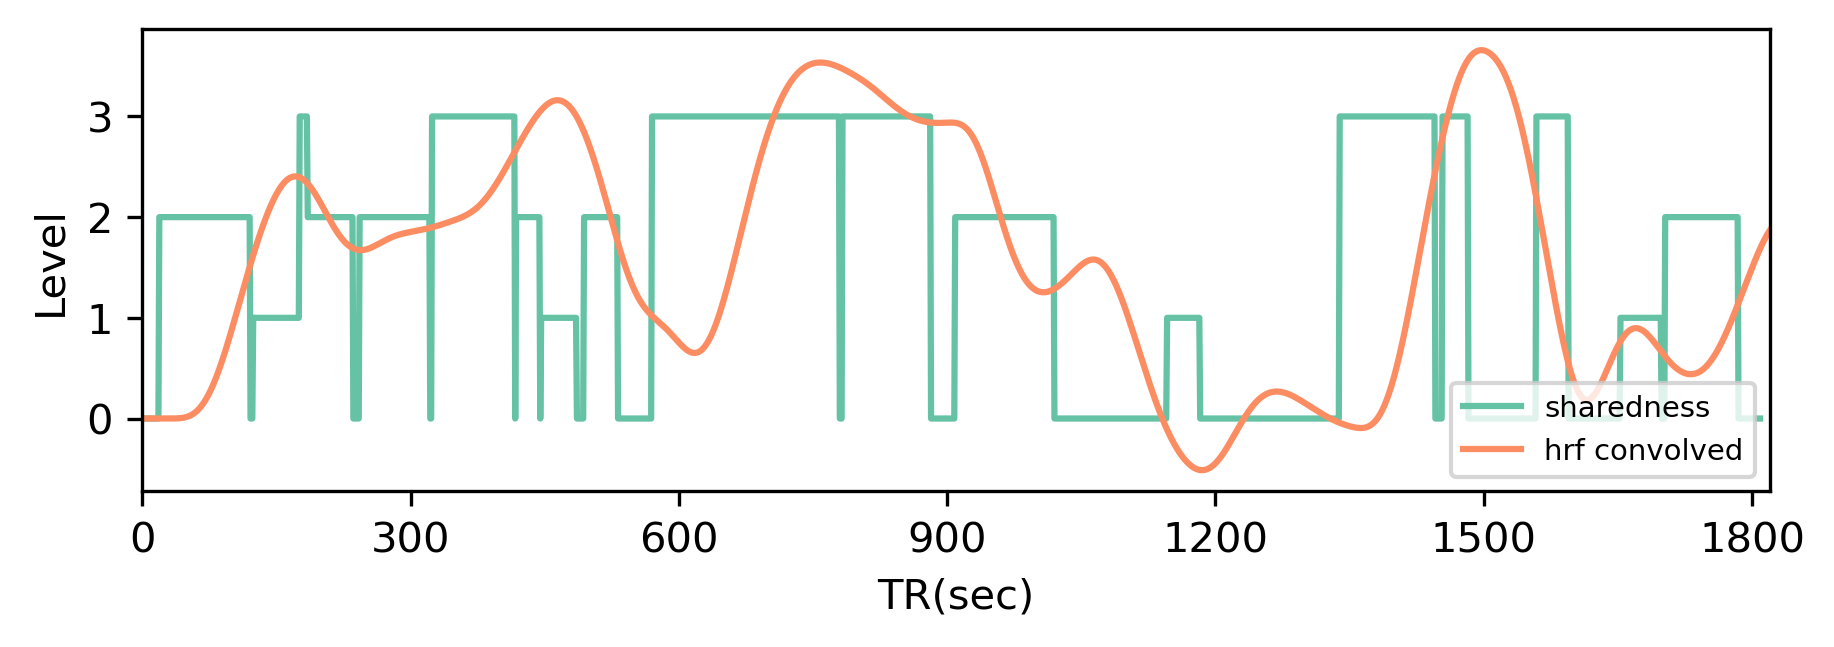

In [211]:
colors = sns.color_palette("Set2")
plt.figure(figsize=(7,2), dpi=300)
plt.plot(X, color=colors[0])
plt.plot(X_hrf, color=colors[1])
plt.xlim(0,1820)
plt.xticks(np.arange(0,1801,300))
plt.xlabel('TR(sec)')
plt.ylabel('Level')
plt.legend(['sharedness','hrf convolved'], fontsize='7', loc='lower right')

# 3. make a DM

In [270]:
group_mot = np.zeros_like(group_brain, dtype='object')
group_beta = np.zeros_like(group_brain, dtype='object')

for group in [2,3,4,5]:
    for sub in [1,2,3]:
        sub_mot = []
        sub_beta = []
        if (group==2 and sub==1):
            runs = [1,2,3]
        else:
            runs = [1]
        for run in runs:
            sub_mot.append(get_motion_params(group,sub,run))
            group_mot[group-2,sub-1] = sub_mot

            # concat all
            lenTR = len(group_mot[group-2,sub-1][run-1][:,0])
            X_sub = np.concatenate([group_reg[group-2,sub-1][run-1][:lenTR].reshape(-1,1), group_mot[group-2,sub-1][run-1]], axis=1)
            
            # calculate beta
            brain = group_brain[group-2, sub-1][run-1]
            regressor = X_sub
            beta = np.dot(np.dot(np.linalg.pinv(np.dot(regressor.T, regressor)), regressor.T), brain.T)
            sub_beta.append(beta)
            group_beta[group-2,sub-1] = sub_beta
        

In [373]:
group_beta_runmean = np.copy(group_beta)

group_beta_runmean[2-2,1-1] = [np.mean([group_beta[0,0][0],group_beta[0,0][1],group_beta[0,0][2]], axis=0)]

beta_mean = []
for group in groups:
    beta_mean.append(np.mean(np.array((group_beta_runmean[group-2,0][0][0], group_beta_runmean[group-2,1][0][0], group_beta_runmean[group-2,2][0][0])), axis=0))
beta_mean = np.mean(np.array(beta_mean),axis=0)
beta_mean.shape
# np.save("output/230607 beta mean.npy", beta_mean)

(69831,)

In [360]:
from scipy.stats import ttest_1samp
T_values = []
p_values = []
beta_mean = []
for i in range(1,69831+1):
    testbed = []
    for group in groups:
        for sub in [1,2,3]:
            testbed.append(group_beta_runmean[group-2,sub-1][0][0][i-1])
    T, p = ttest_1samp(testbed, popmean=0.0)
    T_values.append(T)
    p_values.append(p)

In [393]:
empty_brain = np.zeros_like(brain_mask)

beta_mean[np.array(p_values)>0.05] = np.nan
empty_brain[brain_mask==1] = beta_mean
empty_brain[empty_brain==0.0] = np.nan
np.save("output/230607 beta mean map.npy", empty_brain)

In [392]:
beta_mean.shape

(69831,)

In [369]:
from statsmodels.stats import multitest
corrected_p_values = multitest.multipletests(np.array(p_values), method='fdr_bh')[1]
np.where(np.array(corrected_p_values)<0.05)[0].shape

(0,)

In [46]:
beta_mean = np.load("output/230607 beta mean.npy")

In [47]:
brain_mask = nib.load('/home/jiunchoi/OFD/source/MNI152NLin2009cAsym_3mm_mask.nii').get_fdata()

empty_brain = np.zeros_like(brain_mask)

beta_mean[np.argsort(abs(beta_mean))[:(len(beta_mean)//3)*2]] = np.nan
empty_brain[brain_mask==1] = beta_mean
empty_brain[empty_brain==0.0] = np.nan
np.save("output/230609 beta mean thres map.npy", empty_brain)

In [32]:
beta_mean[abs(beta_mean)<np.mean(beta_mean)]

array([], dtype=float64)

In [33]:
np.mean(beta_mean)

0.0

In [43]:
np.argsort(abs(beta_mean))[:(len(beta_mean)//3)*2].shape

(46554,)

In [44]:
np.argsort(abs(beta_mean))[:(len(beta_mean)//3)*2]

array([    0, 46544, 46545, ...,     9,    10,    11])